In [1]:
!pip install torcheval

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torcheval.metrics.functional import bleu_score

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.append('/content/drive/MyDrive/d2l.ai_implementation/chapter11')

In [6]:
from Attention import *
from Transformer import *
from MTFraEng import MTFraEng
from Training import train

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [7]:
PATH = '/content/drive/MyDrive/d2l.ai_implementation/datasets/fra-eng/fra.txt'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [8]:
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
batch_size = 128
learning_rate = 0.001

In [9]:
train_data = MTFraEng(PATH, train=True)
val_data = MTFraEng(PATH, train=False)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [10]:
model = Transformer(
    len(train_data.src_vocab),
    len(train_data.tgt_vocab),
    num_hiddens,
    ffn_num_hiddens,
    num_heads,
    num_blks,
    dropout,
    use_bias=False
).to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [11]:
def loss(pred, label, tgt_pad, criterion):
    mask = (label != tgt_pad)
    loss = criterion(pred, label)
    return (loss * mask).sum() / mask.sum()

In [12]:
epochs = 50
criterion = nn.CrossEntropyLoss(reduction='none')
loss_fn = lambda pred, label: loss(pred, label, train_data.tgt_vocab['<pad>'], criterion)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
train_losses, val_losses = train(
    model,
    DEVICE,
    train_loader,
    val_loader,
    optimizer,
    loss_fn,
    epochs
)

Epoch [1/50]
Train Loss = 8.55709636211395263672
Test Loss = 6.60632705688476562500

Epoch [2/50]
Train Loss = 6.09140336513519287109
Test Loss = 5.49655675888061523438

Epoch [3/50]
Train Loss = 4.74575996398925781250
Test Loss = 4.98542213439941406250

Epoch [4/50]
Train Loss = 3.88398355245590209961
Test Loss = 4.36924934387207031250

Epoch [5/50]
Train Loss = 3.43846756219863891602
Test Loss = 4.79082870483398437500

Epoch [6/50]
Train Loss = 3.15078049898147583008
Test Loss = 4.83422088623046875000

Epoch [7/50]
Train Loss = 2.93875801563262939453
Test Loss = 4.32102775573730468750

Epoch [8/50]
Train Loss = 2.74301511049270629883
Test Loss = 4.32440948486328125000

Epoch [9/50]
Train Loss = 2.59282070398330688477
Test Loss = 4.37102746963500976562

Epoch [10/50]
Train Loss = 2.44813054800033569336
Test Loss = 4.43520498275756835938

Epoch [11/50]
Train Loss = 2.30638158321380615234
Test Loss = 4.27415752410888671875

Epoch [12/50]
Train Loss = 2.16945242881774902344
Test Loss = 4

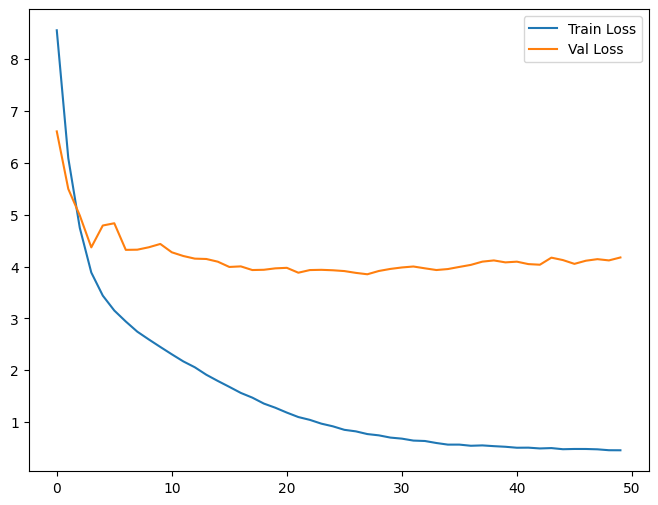

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()

plt.show()

In [19]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
batch = train_data.build(engs, fras)
preds = model.predict_step(batch, DEVICE, train_data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in train_data.tgt_vocab.lookup_tokens(p.tolist()):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu: {bleu_score(" ".join(translation), [fr], n_gram=2)}')

go . => ['va', '!'], bleu: 1.0
i lost . => ["j'ai", 'perdu', '.'], bleu: 1.0
he's calm . => ['<unk>', '.'], bleu: 0.0
i'm home . => ['je', 'suis', 'triste', '.'], bleu: 0.3894003927707672
